In [35]:
import re 
import matplotlib.pyplot as plt
import numpy as np 
import cv2
from glob import glob 
import os 
import nibabel as nib 
import torch 
import torch.nn as nn 
from skimage.transform import resize

In [67]:
def convert_label_to_class(mask):
    lookup_table = {
        0.0: 0.0,
        500.0: 1.0,
        600.0: 2.0,
        420.0: 3.0,
        550.0: 4.0,
        205.0: 5.0,
        820.0: 6.0,
        850.0: 7.0,
    }

    for i in np.unique(mask):
        mask[mask == i] = lookup_table[i]

def one_hot_encode(mask): 
    unique_value = [0.0,
                    500.0,
                    600.0,
                    420.0,
                    550.0,
                    205.0,
                    820.0,
                    850.0]
    
    output = [np.where(mask == x, 1, 0) for x in unique_value]
    output = np.stack(output, axis=0) 
    return output 

def normalize_image_intensity_range(img):
    HOUNSFIELD_MAX = np.max(img) 
    HOUNSFIELD_MIN = np.min(img) 
    HOUNSFIELD_RANGE = HOUNSFIELD_MAX - HOUNSFIELD_MIN

    img[img < HOUNSFIELD_MIN] = HOUNSFIELD_MIN
    img[img > HOUNSFIELD_MAX] = HOUNSFIELD_MAX

    return (img - HOUNSFIELD_MIN) / HOUNSFIELD_RANGE


def save_image(img_path: str, nii_index: int, view: str = "axial"):
    array = nib.load(img_path).get_fdata()
    array = normalize_image_intensity_range(array)

    if view == "axial":
        for i in range(array.shape[-1]):
            img_slice = array[:, :, i]
            img_name = f"heart{nii_index}-slice{str(i).zfill(3)}_axial"
            img = cv2.resize(img_slice, (256, 256))
            img = np.uint8(img * 255)

            path = os.path.join("files", "images", f"{img_name}.png")

            print(f"Image name: {img_name}")

            res = cv2.imwrite(path, img)
            if not res:
                print(f"Error, unable to save image with name: {img_name}")


def save_mask(mask_path: str, nii_index: int, view="axial"):
    output = nib.load(mask_path).get_fdata()

    if view == "axial":
        for i in range(output.shape[2]):
            mask_name = f"heartmaskencode{nii_index}-slice{str(i).zfill(3)}_axial"
            print(f"Mask name: {mask_name}", end=" || ")

            mask = output[:, :, i] 

            encoded_mask = one_hot_encode(mask)
            encoded_mask_reshape = resize(encoded_mask, (8, 256, 256), preserve_range=True, anti_aliasing=True)
            encoded_mask_reshape = np.argmax(encoded_mask_reshape, axis=0) 

            convert_label_to_class(mask) 
            print(f"Mask unique: {np.unique(mask)}", end=" || ")
            print(f"Mask reshape unique: {np.unique(encoded_mask_reshape)}")
   
            path = os.path.join("files", "masks", f"{mask_name}.npy")
            np.save(path, encoded_mask_reshape)


def volumetric_to_slice(image_path, mask_path, view="axial"):
    image_sub = sorted(glob(os.path.join(image_path, "*_image.nii.gz")))
    mask_sub = sorted(glob(os.path.join(mask_path, "*_label.nii.gz")))

    if view == "axial":
        for nii_index in range(len(image_sub)):
            image_path = image_sub[nii_index]
            mask_path = mask_sub[nii_index]

            save_mask(mask_path, nii_index, view=view)
            save_image(image_path, nii_index, view=view)

In [ ]:
class OneHotResizing(): 
    def __init__(self, categories="auto", dtype=np.float32): 
        self.categories = categories 
        self.dtype = dtype

    def one_hot_encode(self, mask): 
        if not isinstance(mask, np.array): 
            mask = np.array(mask) 
    
        if self.categories == "auto": 
            unique_values = sorted(np.unique(mask)) 
        else: 
            unique_values = self.categories

        output = [np.where(mask == x, 1, 0) for x in unique_values]
        output = np.stack(output, axis=0) 
        return output 

    def resize(self, mask, new_shape): 
        encoded_mask = one_hot_encode(mask)

        try: 
            encoded_mask_reshape = resize(
                encoded_mask, new_shape, preserve_range=True, anti_aliasing=True)
        except Exception as e: 
            print(f"Resizing operation not succesful, function returning None")
            print(f"{e}")
            return None
        
        encoded_mask_reshape = np.argmax(encoded_mask_reshape, axis=0)
        encoded_mask_reshape = encoded_mask_reshape.astype(self.dtype)

        return encoded_mask_reshape

In [56]:
from skimage.transform import resize

def one_hot_encode(mask):
    unique_value = [0.0,
                    500.0,
                    600.0,
                    420.0,
                    550.0,
                    205.0,
                    820.0,
                    850.0]

    output = [np.where(mask == x, 1, 0) for x in unique_value]
    output = np.stack(output, axis=0)
    return output


a = nib.load(
    "../data_for_training/MMWHS/ct_train/ct_train_1001_label.nii.gz").get_fdata()[:, :, 260]
encoded_a = one_hot_encode(a)

encoded_a_reshape = resize(encoded_a, (8, 256, 256), preserve_range=True, anti_aliasing=True)

encoded_a_reshape = np.argmax(encoded_a_reshape, axis=0) 

convert_label_to_class(a)


print(f"Mask label: {np.unique(a)}")


print(f"Mask reshape label: {np.unique(encoded_a_reshape)}")


fig, axes = plt.subplots(nrows=1, ncols=2) 



axes[0].imshow(a) 



axes[1].imshow(encoded_a_reshape)

KeyError: 2.0

In [68]:
image_path = "../data_for_training/MMWHS/ct_train/"
mask_path = "../data_for_training/MMWHS/ct_train/"

In [69]:
volumetric_to_slice(image_path, mask_path)

Mask name: heartmaskencode0-slice000_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice001_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice002_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice003_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice004_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice005_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice006_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice007_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice008_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice009_axial || Mask unique: [0.] || Mask reshape unique: [0]
Mask name: heartmaskencode0-slice010_axial || Mask unique: [0.] || Mask reshape 

## TEST NUMPY SAVED MASK 

In [63]:
mask = np.load("./files/masks/heartmaskencode2-slice150_axial.npy")

In [64]:
print(mask.shape, np.unique(mask), len(np.unique(mask))) 

(512, 512) [0. 1. 2. 3. 4. 5. 6.] 7


In [65]:
image = cv2.imread("./files/images/heart2-slice150_axial.png", cv2.IMREAD_GRAYSCALE)

Text(0.5, 0, 'IMAGE')

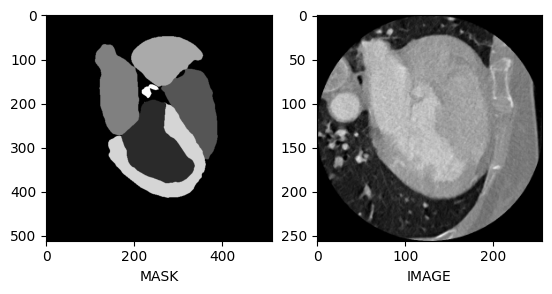

In [66]:
fig, axes = plt.subplots(nrows=1, ncols=2) 

axes[0].imshow(mask, cmap="gray") 
axes[0].set_xlabel("MASK") 

axes[1].imshow(image, cmap="gray")
axes[1].set_xlabel("IMAGE")